In [1]:
# %matplotlib widget
# %matplotlib tk
import godot

import numpy as np
from godot.core import tempo, util
import matplotlib.pyplot as plt
import pickle


# optionally avoid verbose logging messages
import godot.core.util as util
util.suppressLogger()

import os
os.makedirs('./output/',exist_ok = True)

# create the universe
uni_config = godot.cosmos.util.load_yaml('universe2.yml')
uni = godot.cosmos.Universe(uni_config)

In [2]:
year = 2026
filename = './output/year_sim/one_year_' + str(year) + '.pickle'
with open(filename, 'rb') as f:
    res = pickle.load(f)
res.add_los_coloumns()

In [3]:
print('loaded!')
e = res.elv('NN11_elev')
print(type(e.values))

loaded!
<class 'numpy.ndarray'>


In [4]:
import mani_rain
from mani.StateEvaluator import SEEnum
condition = res.above_elev('NN11_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
elevations = res.df.loc[condition]['NN11_elev']

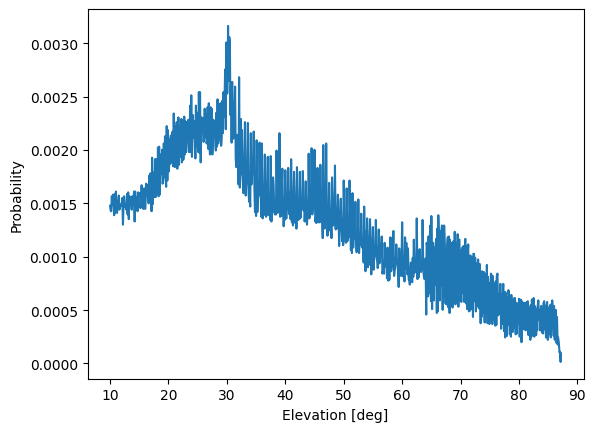

In [5]:
with open('./output/elevations/NN11_elevations.pickle', 'wb') as f:
    pickle.dump(elevations, f, protocol=pickle.HIGHEST_PROTOCOL)
nn = mani_rain.new_norcia
nn.gen_el_dist(file='./output/elevations/NN11_elevations.pickle')

plt.figure()
plt.plot(*nn.el_distribution)
plt.xlabel("Elevation [deg]")
plt.ylabel("Probability")
plt.show()

link = mani_rain.link_budget_itu(nn, 100e6)
# dist = 384400e3
# rain_rate = 4 #mmhr⁻¹
# rain_rates = np.full(len(elevations), rain_rate)
# snr_list = []
# for idx, el in enumerate(elevations):
#     snr_list.append(link.snr_at_t(dist, el, rain_rates[idx]))
# plt.figure()
# plt.plot(elevations, snr_list)
# plt.grid()
# plt.xlabel("Elevation [Deg]")
# plt.ylabel("SNR [dB]")
# plt.show()

In [6]:
rain_p = 0.5
dist = 384400e3
elev = 45
%timeit link.rain_model.p = rain_p
snr = link.snr_at_t(dist, elev)
rates = link.dvb_s2_cap(snr)

3.19 ms ± 181 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from tqdm import tqdm


aau = mani_rain.station_t (
    -31.016434952605326,
    116.19856261578303,
    0.221+0.04,
    32,
    55.8,
    6,
    _esa_dsa_eff)


link = mani_rain.link_budget_itu(aau, 100e6,link_margin=6)

generator = np.random.default_rng()
does_rain_p = generator.binomial(1, 0.028, res.get_length())

hmr = generator.uniform(0.01, 2.8, sum(does_rain_p))
idx = 0

rainrates = np.empty_like(does_rain_p)
for i, _ in enumerate(tqdm(rainrates)):
    if does_rain_p[i] > 0:
        link.rain_model.p = hmr[idx]
        rainrates[i] = link.rain_model.rain_rate
        idx += 1
    else:
        rainrates[i] = 0
print(rainrates.shape)


condition = res.above_elev('NN11_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])

snrs = np.empty(res.get_length())
rates = np.empty(res.get_length())

for i in tqdm(range(res.get_length())):
    dist = res.df.iloc[i]['NN11_dist'] * 1e3
    elev = res.df.iloc[i]['NN11_elev']
    if condition[i]:
        snrs[i] = link.snr_at_t(dist, elev, rainrates[i])
        rates[i] = link.dvb_s2_cap(snrs[i])
    else:
        snrs[i] = 0
        rates[i] = 0

100%|██████████| 525601/525601 [00:49<00:00, 10547.99it/s]


(525601,)


100%|██████████| 525601/525601 [00:24<00:00, 21254.74it/s]


In [8]:
link.rain_model.p = 2.8
link.rain_model.rain_rate

0.04362314949498465

In [9]:
# plt.figure()
# plt.plot(res.df['NN11_elev'])
# print(dist)
# print(link.snr_at_t(dist * 1e3, -10, 0))
# plt.show()

[ 0.          0.          0.         ... 14.12792842 14.12914806
 14.13027676]


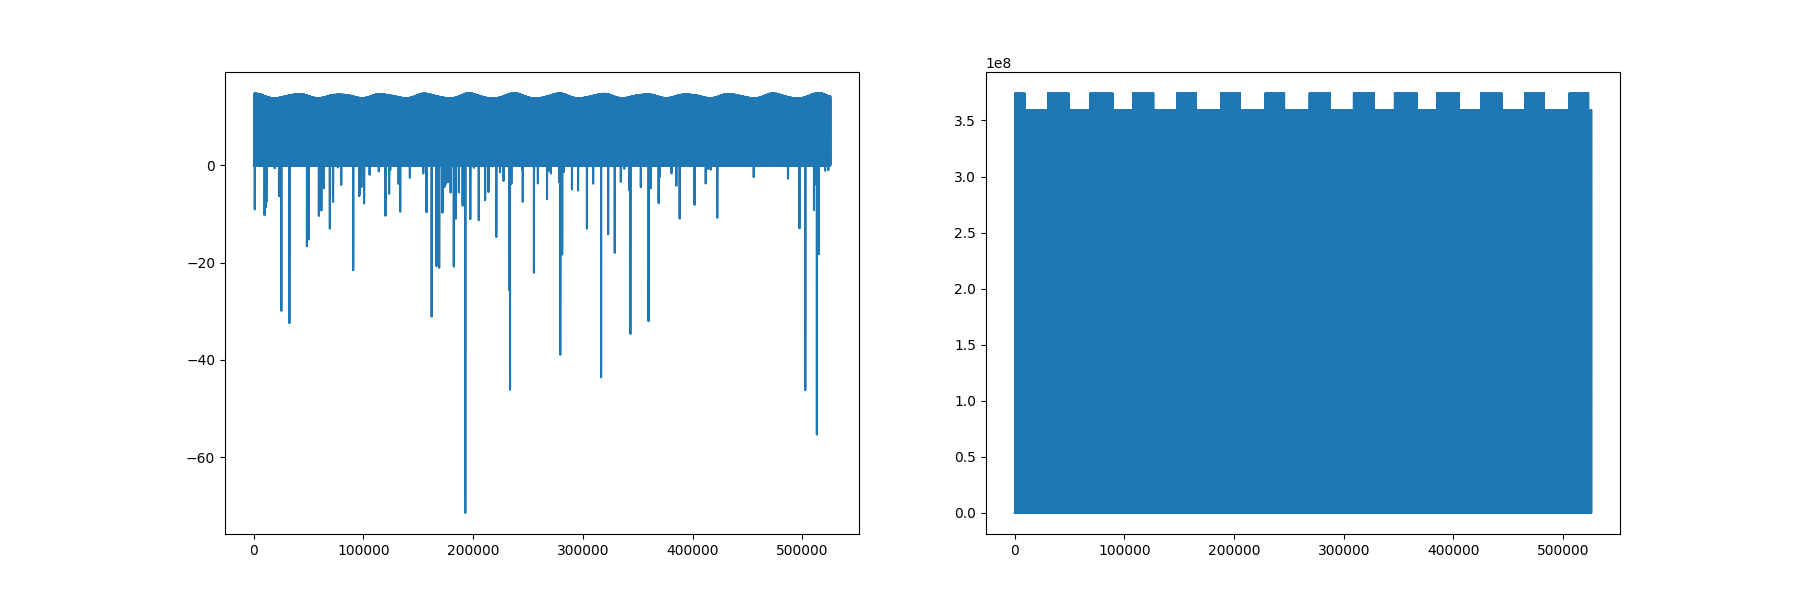

93.62397750540462


In [10]:
%matplotlib widget
fig = plt.figure(figsize=(18, 6))
ax0, ax1 = fig.subplots(1,2)
ax0.plot(snrs)
#ax0.plot(res.df['NN11_elev'], alpha = 0.5)
print(snrs)
ax1.plot(rates)
plt.show()
print(np.mean(rates) / 1e6)

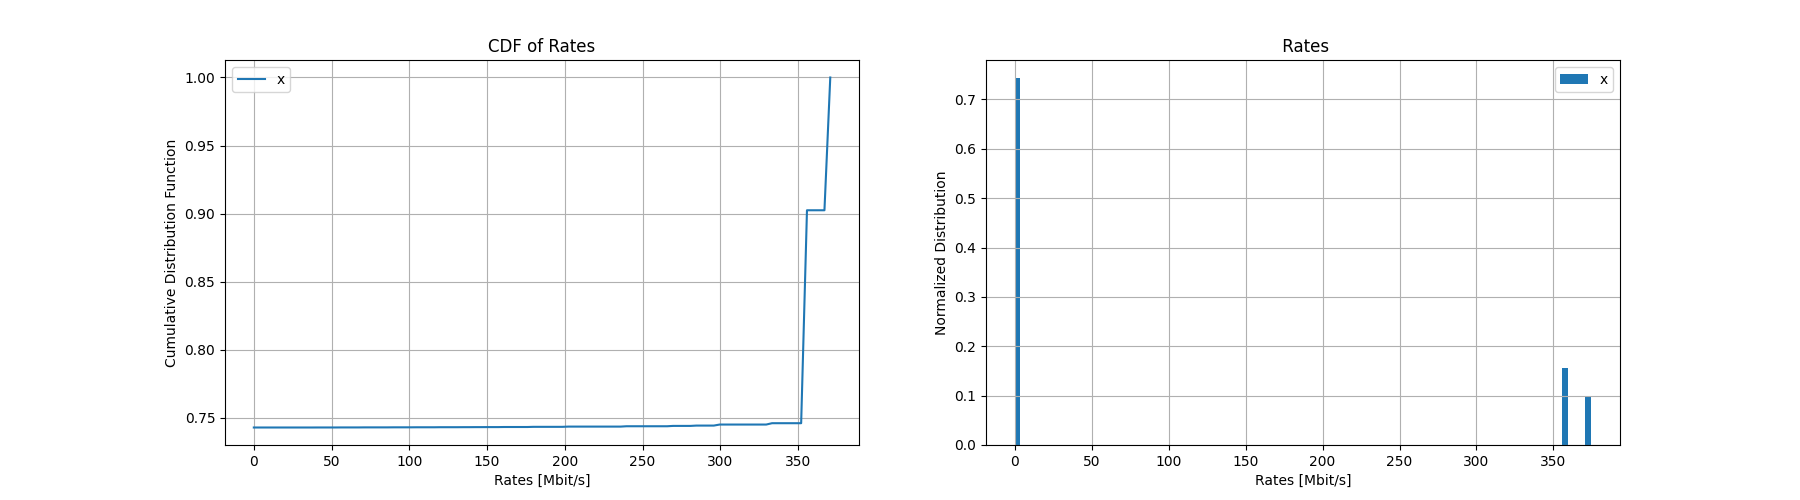

In [11]:
def plot_cdf(ax, bins,vals, name):
    ax.plot(bins[:-1], np.cumsum(vals), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Cumulative Distribution Function')
    ax.legend()
    ax.set_title('CDF of Rates')

def plot_hist(ax, arr, name):
    ax.hist(arr, bins = 100, weights=np.ones(len(arr)) / len(arr), label = name)
    ax.grid()
    ax.set_xlabel('Rates [Mbit/s]')
    ax.set_ylabel('Normalized Distribution')
    ax.set_title(' Rates')
    ax.legend()


fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
arr = rates / 1e6

name = 'x'
vals, bins = np.histogram(arr, bins=100, weights=np.ones(len(arr)) / len(arr))
plot_cdf(ax0, bins, vals, name)

plot_hist(ax1, arr, name)

plt.show()

In [16]:
idx = 0
condition = res.above_elev('NN11_elev', 10.0) & res.has([SEEnum.CLEAR_MOON_NN])
for i in tqdm(range(len(condition))):
    if (condition[i]) & (rates[i] == 0):
        idx += 1
print(idx)
print(idx / len(condition))

100%|██████████| 525601/525601 [00:00<00:00, 600697.01it/s]

91
0.000173135134826608


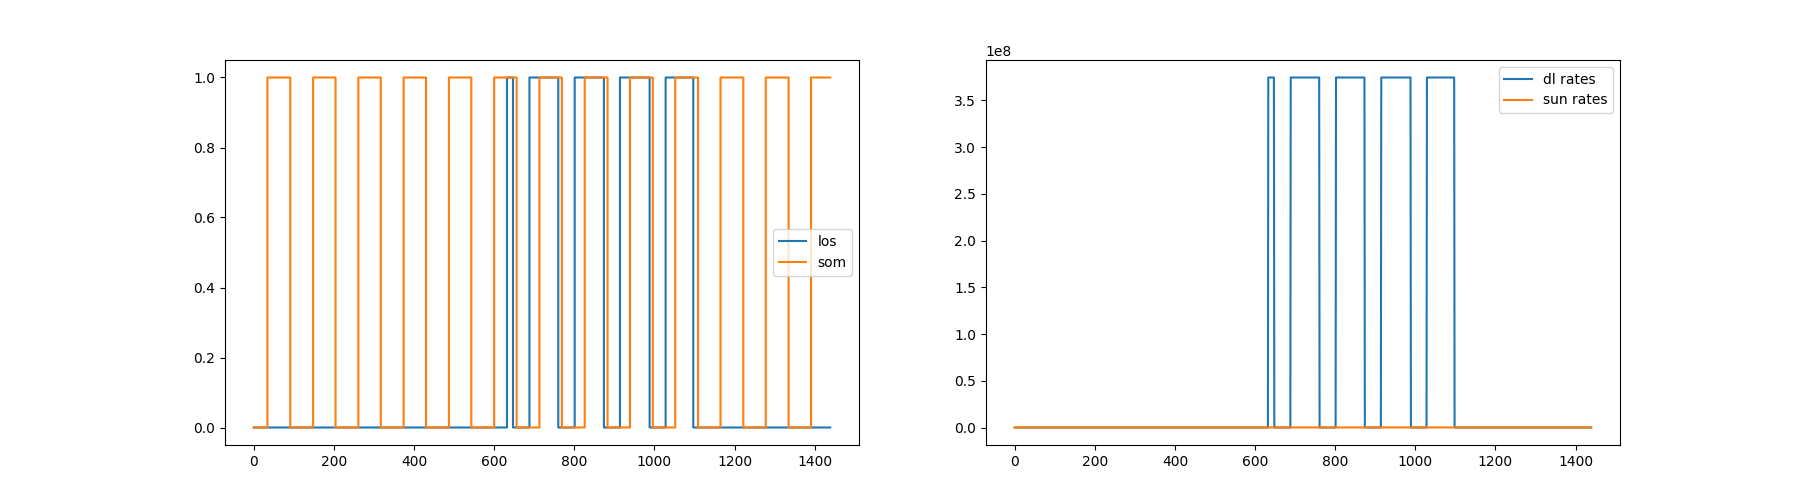

In [15]:
n = 0
m = 24*60
rs = [4.5 * 1e9 / (24*60*60)] * m
rd = rates[n:n+m]
los = res['los_nn'][n:n+m].values
som = res.has([SEEnum.SUN_ON_MOON])[n:n+m].values
fig = plt.figure(figsize = (18,5))
ax0, ax1 = fig.subplots(1,2)
ax0.step(range(m), los, label = 'los')
ax0.step(range(m), som, label = 'som')
ax0.legend()

ax1.plot(range(m), rd, label='dl rates')
ax1.plot(range(m), rs, label='sun rates')
ax1.legend()
plt.show()


with open('./tmp/los.pickle', 'wb') as f:
    pickle.dump(los,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/som.pickle', 'wb') as f:
    pickle.dump(som,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/rs.pickle', 'wb') as f:
    pickle.dump(rs,f,protocol=pickle.HIGHEST_PROTOCOL)

with open('./tmp/rd.pickle', 'wb') as f:
    pickle.dump(rd,f,protocol=pickle.HIGHEST_PROTOCOL)